In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset

In [ ]:
!gdown 'https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a'
!gdown 'https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00'
!gdown 'https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ'

Downloading...
From: https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a
To: /content/Handwritten_V2_train.csv
100% 35.3M/35.3M [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00
To: /content/Handwritten_V2_valid.csv
100% 11.7M/11.7M [00:00<00:00, 57.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ
To: /content/Handwritten_V2_test.csv
100% 13.0M/13.0M [00:00<00:00, 69.4MB/s]


In [ ]:
train = pd.read_csv("/content/Handwritten_V2_train.csv")
test = pd.read_csv("/content/Handwritten_V2_test.csv")
validate = pd.read_csv("/content/Handwritten_V2_valid.csv")

In [ ]:
train_images = train.iloc[:, 1:].values
test_images = test.iloc[:, 1:].values
train_labels = train.iloc[:, 0].values
test_labels = test.iloc[:, 0].values
validate_labels = validate.iloc[:, 0].values
validate_images = validate.iloc[:, 1:].values

In [ ]:
np.unique(train_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

In [ ]:
train_images = np.concatenate([train_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
test_images = np.concatenate([test_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
validate_images = np.concatenate([validate_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)

In [ ]:
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])

In [ ]:
train_images.shape

TensorShape([17235, 32, 32, 3])

## One hot encoding

In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
validate_labels = to_categorical(validate_labels)

In [ ]:
train_labels.shape

(17235, 86)

In [ ]:
base_model = MobileNetV3Small(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
base_model.trainable = False

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:
base_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 32, 32, 3)      │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 16, 16, 16)     │            432 │ rescaling_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 16, 16, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_90             │ (None, 16, 16, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 17, 17, 16)     │              0 │ activation_90[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 8, 8, 16)       │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 8, 8, 16)       │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_70 (ReLU)           │ (None, 8, 8, 16)       │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu_70[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_45 (Add)              │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_71 (ReLU)      

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(86, activation='softmax')(x)
model = Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=40, validation_data=(validate_images, validate_labels))

Epoch 1/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.0304 - loss: 4.4378 - val_accuracy: 0.0792 - val_loss: 4.0829
Epoch 2/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0896 - loss: 4.0070 - val_accuracy: 0.1267 - val_loss: 3.7966
Epoch 3/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1243 - loss: 3.7529 - val_accuracy: 0.1434 - val_loss: 3.5994
Epoch 4/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1462 - loss: 3.5804 - val_accuracy: 0.1648 - val_loss: 3.4523
Epoch 5/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1667 - loss: 3.4517 - val_accuracy: 0.1776 - val_loss: 3.3243
Epoch 6/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1890 - loss: 3.3283 - val_accuracy: 0.2268 - val_loss: 3.2448
Epoch 7/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2031 - loss: 3.2429 - val_accuracy: 0.2163 - val_loss: 3.1660
Epoch 8/40
539/539 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2070 - loss: 3.1806 - val_accuracy: 

In [ ]:
model.evaluate(test_images, test_labels)

199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3953 - loss: 2.4310


[2.618644952774048, 0.3259946405887604]

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
fine_history = model.fit(
    train_images,
    train_labels,
    epochs=90,
    validation_data=(validate_images, validate_labels),
    initial_epoch=history.epoch[-1]
)

Epoch 40/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.0141 - loss: 89.4964 - val_accuracy: 0.0251 - val_loss: 14.8387
Epoch 41/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.0267 - loss: 65.0062 - val_accuracy: 0.0145 - val_loss: 35.5632
Epoch 42/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0407 - loss: 45.7868 - val_accuracy: 0.0177 - val_loss: 30.1740
Epoch 43/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0538 - loss: 30.9166 - val_accuracy: 0.0195 - val_loss: 18.0744
Epoch 44/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0657 - loss: 22.0207 - val_accuracy: 0.0175 - val_loss: 14.4375
Epoch 45/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0772 - loss: 16.9649 - val_accuracy: 0.0394 - val_loss: 14.4248
Epoch 46/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.0823 - loss: 13.6845 - val_accuracy: 0.0563 - val_loss: 13.8318
Epoch 47/90
539/539 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0877 - lo

In [ ]:
model.evaluate(test_images, test_labels)

199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5636 - loss: 1.8283


[1.978421688079834, 0.5074697136878967]

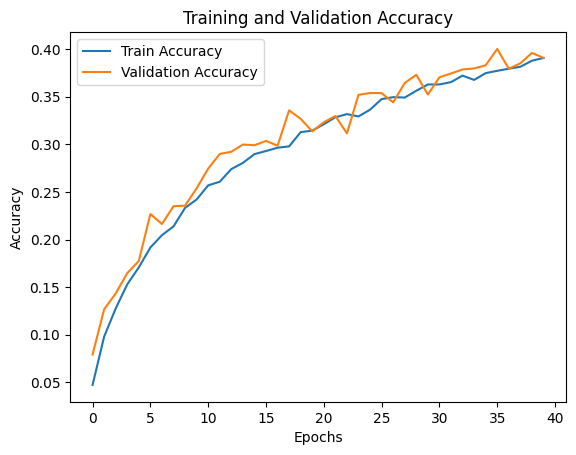

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
model.save('char_recognition_mobilenetv3.keras')